Desicion Tree 

# Imports

In [235]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import re

# Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import nltk

# Preprocess features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Preprocess targets
from sklearn.preprocessing import MinMaxScaler

#LSTM for regression
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Visulization
import matplotlib.pyplot as plt
from sklearn_evaluation import plot

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leamayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

In [2]:
# Select Target Dataset

target_file = "CAvideos_12.csv"

df_target = pd.read_csv("../Data/processed_data/"+target_file)
df_target = df_target.dropna()

df_target = df_target [["channel_title","tags","description","views"]]

df_target["views"] = df_target["views"].astype(int)

# Create Source Data Set

folder_path = "../Data/processed_data"  # Path to processed df
iterator = 0
frames = []

# Iterate over files in the folder
for file_name in os.listdir(folder_path):

    if file_name.endswith('.csv') and file_name != target_file:  # Process only CSV files

        df = pd.read_csv("../Data/processed_data/"+file_name)
        df = df.dropna()

        df = df [["channel_title","tags","description","views"]]

        df["views"] = df["views"].astype(int)

        frames.append(df)

df_source = pd.concat(frames)

print(f">>> Created target df ({len(df_target)}) and source df ({len(df_source)})")

>>> Created target df (6039) and source df (111959)


In [3]:
# Select subset

df_target = df_target [:10000]

df_source = df_source [:10000]

In [4]:
# Loas features and targets

feature_df = df_source [["channel_title","tags","description"]]  # Text data as numpy list
targets = df_source["views"].to_numpy()  # Target data as numpy list


## Preprocessing

### Normalize Targets

In [5]:
# Normalizing the target values with the min-max normalization

scaler = MinMaxScaler()
normalized_targets = scaler.fit_transform(targets.reshape(-1, 1)).flatten()

print(f">>> Range from original targets ({targets.min()};{targets.max()}) has been normalized ({normalized_targets.min()};{normalized_targets.max()})")

>>> Range from original targets (1141;225211923) has been normalized (0.0;1.0)


### Image Preprocessing

### Apply Stemmer and Remove Stopwords from Text Features

In [6]:
# Add content speficic stopwords by select the top N words with the highest TF-IDF scores as potential stopwords

def get_content_stopwords(texts):
    
    vectorizer = TfidfVectorizer() # TfidfVectorizer object from sklearn

    tfidf_matrix = vectorizer.fit_transform(texts) 

    feature_names = vectorizer.get_feature_names_out()

    avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0] # Get average TF-IDF score for each word

    word_scores = list(zip(feature_names, avg_tfidf_scores))

    word_scores.sort(key=lambda x: x[1], reverse=True) # Sort the word_scores in descending order

    N = 250 # Number of stopwords to select
    stopwords_content = [word for word, score in word_scores[:N]] # Potential stopwords

    print(f">>> {len(stopwords_content)} content specific stopwords are identified")

    return stopwords_content

In [7]:
# Define stemmer and stopwords

def get_stopwords(texts):

    # Stopwords
    stop_words_nlkt = set(stopwords.words('english'))

    # add contect speficic stopwords 
    original_stopword_len = len(stop_words_nlkt)

    stop_words = stop_words_nlkt.copy()

    stop_words |= set(get_content_stopwords(texts)) # Add the additional wikipedia specific stopwords

    merged_stopword_len = len(stop_words)

    print(f">>> {merged_stopword_len-original_stopword_len} additional stopwords have been added to the nlkt stopwords list")

    return stop_words

In [52]:
# Get Stemmer
stemmer = SnowballStemmer('english')
feature_df_preprocessed = pd.DataFrame()


for feature in feature_df:

    print(f"\n--- Preprocessing {feature} feature ---\n")

    texts = feature_df[feature].to_numpy()

    # Remove numbers and singel characters

    texts_preprocessed = [' '.join([word for word in text.split() if not word.isnumeric()]) for text in texts] # Remove numbers
    texts_preprocessed = [' '.join([word for word in text.split() if not len(word) > 1]) for text in texts] # Remove words with one character

    print(">>> Numbers and words with only one character are removed")

    # Get Stopwords
    stop_words = get_stopwords(texts)

    # Remove stop words from the text data and apply stemmer

    texts_preprocessed = [' '.join([stemmer.stem(word) for word in text.split() if word.lower() not in stop_words]) for text in texts]

    feature_df_preprocessed[feature] = texts_preprocessed

    print(">>> The Stemmer and the Stopword Removal are applied f.e.:\n")

    print (texts[5]) # show example
    print (texts_preprocessed[5])


--- Preprocessing channel_title feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 239 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

DramaAlert


--- Preprocessing tags feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 225 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

#DramaAlert|"Drama"|"Alert"|"DramaAlert"|"keemstar"|"youtube news"|"jake paul"|"team 10"|"alissa violet"|"cheated"|"logan paul"|"logan paul alissa violet"|"jake paul alissa violet"|"Martinez Twins"|"left team 10"|"faze banks"|"erika costell"
#dramaalert|"drama"|"alert"|"dramaalert"|"keemstar"|"youtub news"|"jak paul"|"team 10"|"alissa violet"|"cheated"|"logan paul"|"logan alissa violet"|"jak alissa violet"|"martinez twins

In [53]:
feature_df_preprocessed

,channel_title,tags,description
0,eminemvevo,"eminem|""walk""|""on""|""water""|""aftermath/shady/in...",eminem track walk water ft. beyoncã© everywher...
1,idubbbztv,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",still lot packages. probabl last anoth year. s...
2,,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",previous â¶ \n\nsubscrib âº https://www.yout...
3,,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...","sinc show, we'r might yet!\nleav dare comment ..."
4,sheeran,"edsheeran|"" sheeran""|""acoustic""|""live""|""cover""...",ð§: https://ad.gt/yt-perfect\nð°: https://...
...,...,...,...
9995,theodd2sout,dumb joke,hate everyth woodi woodpeck review: https://ww...
9996,what,[none],"cett semaine, jerr allain recoit au what #60 m..."
9997,okay.africa,"oook.sn|""senegaltv""|""maroditv""|""leuztv""|""walft...",cet ã©pisod final saison 2 est le vrai mbettel...
9998,,"hacks|""cheap hacks""|""amaz hacks""|""10 need coll...",hack react colleg kids! \nsubscrib hit ð! 1...


### Tokenize and Split the Text Data

Keine Feature Extraction -> Text direkt als Input wie bei NN

In [79]:
def encoding(df):# encode remaining objects

    tokenizer = Tokenizer(
        num_words=10000,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    )

    for column in df:

        # Check if column is of type object
        if df[column].dtype == 'object' and column != "video_id":

            df[column] = df[column].astype(str)

            print(f">>> {column} is of type object and will be encoded")

            tokenizer.fit_on_texts(df[column])

            # Get the word index
            word_index = tokenizer.word_index

            # Convert texts to sequences
            sequences = tokenizer.texts_to_sequences(df[column])

            df[column] = sequences

            # Create separate columns for each element in the list
            df_expanded = pd.DataFrame(df[column].to_list(), columns=[f"{column}_{i+1}" for i in range(df[column].str.len().max())])
            
            # Concatenate expanded columns with the original DataFrame
            df = pd.concat([df.drop(column, axis=1), df_expanded], axis=1)
                
    return df
        

In [82]:
encoded_df = encoding(feature_df_preprocessed.copy())

>>> channel_title is of type object and will be encoded
>>> tags is of type object and will be encoded
>>> description is of type object and will be encoded


In [85]:
encoded_df = encoded_df.fillna(0)

encoded_df

,channel_title_1,channel_title_2,channel_title_3,channel_title_4,channel_title_5,channel_title_6,tags_1,tags_2,tags_3,tags_4,...,description_677,description_678,description_679,description_680,description_681,description_682,description_683,description_684,description_685,description_686
0,223.0,0.0,0.0,0.0,0.0,0.0,919.0,545.0,173.0,501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,577.0,0.0,0.0,0.0,0.0,0.0,7183.0,244.0,284.0,284.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1469.0,1576.0,2959.0,965.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,252.0,3298.0,3057.0,2842.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1150.0,0.0,0.0,0.0,0.0,0.0,3564.0,3953.0,29.0,384.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,246.0,0.0,0.0,0.0,0.0,0.0,3850.0,507.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,504.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,1077.0,1078.0,0.0,0.0,0.0,0.0,4024.0,9139.0,9138.0,9137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,175.0,179.0,175.0,1464.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training

### Grid Search for best Hyperparameters

In [243]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(encoded_df, normalized_targets, test_size=0.2, random_state=42)

# Define DT Instance
regressor = DecisionTreeRegressor()

# Define Parameters for Grid Search
params =  {
    'min_samples_leaf': list(range(1, 30)),
    'max_depth': list(range(1, 60))
}

# Define Grid Search Instance
grid = GridSearchCV(estimator=regressor,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=2)

# Fit the model
grid.fit(X_train, y_train)

# Assess the score
grid.best_score_, grid.best_params_ # max_depth': 29, 'min_samples_leaf': 4}

Fitting 10 folds for each of 1711 candidates, totalling 17110 fits
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=1, min_samples_leaf=2; total time=   0.1s
[CV] END ....................max_depth=1, 

(0.5723595015445967, {'max_depth': 27, 'min_samples_leaf': 3})

### Visulize GrdSearch results

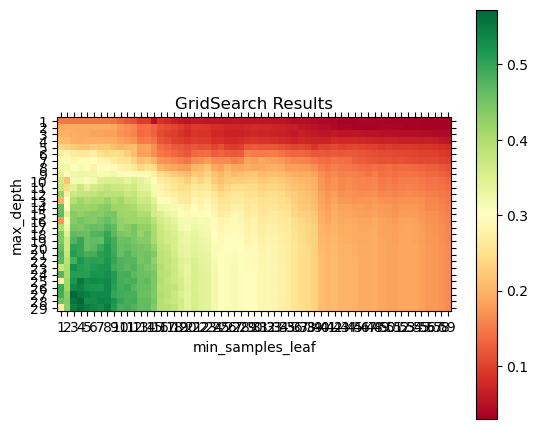

In [244]:
ax = plot.grid_search(grid.cv_results_, change=("max_depth", "min_samples_leaf"), cmap="RdYlGn")

# Remove annotations from plot
for txt in ax.texts:
    txt.set_visible(False)

# Change Scales 
x_ticks = []
for i in ax.get_xticklabels():
    x = re.findall(r'\d+', i.get_text())[0]
    i.set_text(x)
    x_ticks.append(i)
ax.set_xticklabels(x_ticks)

y_ticks = []
for j in ax.get_yticklabels():
    x = re.findall(r'\d+', j.get_text())[0]
    j.set_text(x)
    y_ticks.append(j)
ax.set_yticklabels(y_ticks)

plt.xticks(rotation=0)

# Set titel and labels
plt.title('GridSearch Results')
plt.ylabel('max_depth')
plt.xlabel('min_samples_leaf')
plt.show()

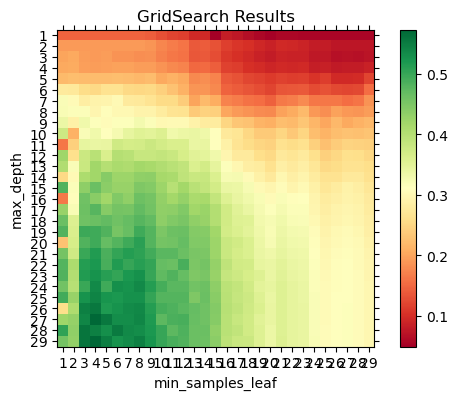

In [242]:
ax = plot.grid_search(grid.cv_results_, change=("max_depth", "min_samples_leaf"), cmap="RdYlGn")

# Remove annotations from plot
for txt in ax.texts:
    txt.set_visible(False)

# Change Scales 
x_ticks = []
for i in ax.get_xticklabels():
    x = re.findall(r'\d+', i.get_text())[0]
    i.set_text(x)
    x_ticks.append(i)
ax.set_xticklabels(x_ticks)

y_ticks = []
for j in ax.get_yticklabels():
    x = re.findall(r'\d+', j.get_text())[0]
    j.set_text(x)
    y_ticks.append(j)
ax.set_yticklabels(y_ticks)

plt.xticks(rotation=0)

# Set titel and labels
plt.title('GridSearch Results')
plt.ylabel('max_depth')
plt.xlabel('min_samples_leaf')
plt.show()

### Model Training

In [96]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(encoded_df, normalized_targets, test_size=0.2, random_state=42)

# Train decision tree regressor with best parameters
regressor = DecisionTreeRegressor()#max_depth = 9, min_samples_leaf = 1)
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

### Save Model

In [ ]:
model.save('source_lstm_model.h5')
model.save_weights('source_lstm_model_weights.h5')

# Model Evaluation

### Prediction

In [104]:
# Prediction
pred = regressor.predict(X_test)

# Convert normalized predictions back to original scale
original_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluation metrics
mse = mean_squared_error(original_targets, original_pred)
mape = mean_absolute_percentage_error(original_targets, original_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 5701406547850.696
Mean Absolute Percentage Error (MAPE): 3.832325004481315
Root Mean Squared Error (RMSE): 2387761.8281249693


### Visulization

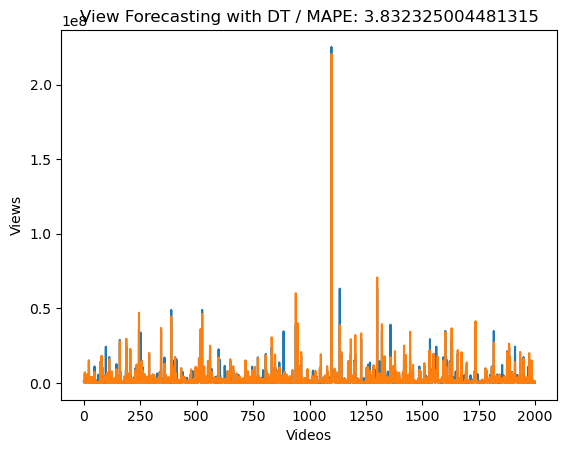

In [108]:
plt.plot(original_pred)
plt.plot(original_targets)
plt.title('View Forecasting with DT / MAPE: '+ str(mape))
plt.xlabel('Videos')
plt.ylabel('Views')
plt.show()

### Check Feature Importance

In [92]:
# Create a DataFrame with Feature Importances
feature_importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

importance_df = importance_df.transpose()
importance_df.columns = importance_df.iloc[0]
importance_df = importance_df.drop('Feature')

# Sum encoded columns
column_list = ['tags_\d+','channel_title_\d+','description_\d+','title_\d+']

for i in column_list:

    filter_columns = importance_df.filter(regex=i)

    # Replace encoded columns with aggregated column
    importance_df = importance_df.drop(filter_columns, axis=1)
    importance_df[i[:-4]] = filter_columns.sum(axis=1)

# Clean importance_df for visualization
importance_df = importance_df.transpose()
importance_df = importance_df.reset_index()
importance_df = importance_df.sort_values('Importance', ascending=False)

importance_df

,Feature,Importance
2,description,0.680929
0,tags,0.297003
1,channel_title,0.022068
3,title,0.0


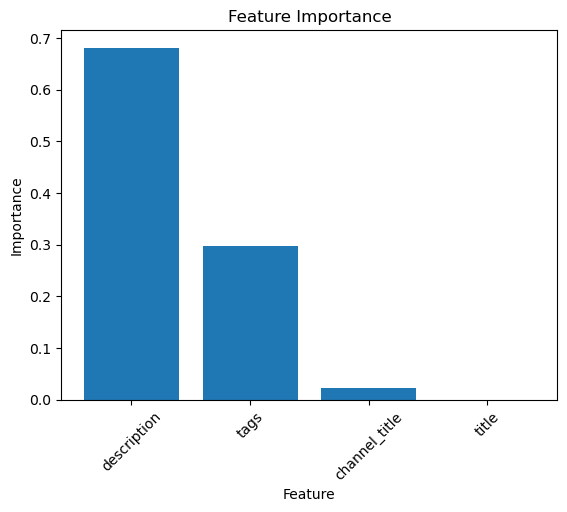

In [93]:
# Create a bar plot of feature importances
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()